# Alchemical PES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.offsetbox import AnchoredText
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 12

from apdft_tools.utils import *
from apdft_tools.prediction import *
from apdft_tools.data import prepare_dfs
from apdft_tools.analysis import *

json_path = '../../json-data/atom-pyscf.apdft-data.posthf.json'
df_qc, df_apdft = prepare_dfs(json_path, get_CBS=False)

## Alchemical PES system specifications

Note that the default plot setups will have to change if `n_electrons` is less than 3

In [2]:
n_electrons = 6
excitation_level = 0
sys_type = 'atom'
basis_set = 'aug-cc-pV5Z'

### Lollipop

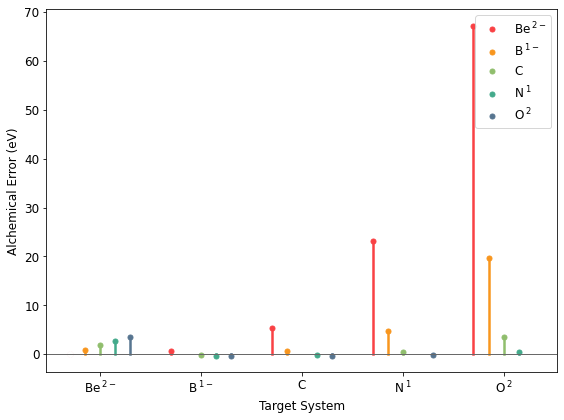

In [3]:
return_energies = False

state_labels, all_energies = get_alchemical_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=return_energies
)

system_labels_condensed = []
for state_label in state_labels:
    split = state_label.split('.')
    sys_label = split[0].capitalize()
    charge = str(split[1][4:])
    if charge[0] == '-':
        charge = charge[1] + '-'
    if charge == '0':
        charge = ''
    system_labels_condensed.append(sys_label + '$\,^{' + charge + '}$')

marker_size = 5
line_width = 2.5
j_offset = 0.15


###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
sys_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]

for i in range(len(system_labels_condensed)):
    energies = hartree_to_ev(all_energies[i,:])

    x = [i+j*j_offset for j in range(i+len(energies))]
    for j in range(len(system_labels_condensed)):
        if i == j and i != 0:
            color = 'white'
        else:
            color = sys_colors[j]
        
        ax.plot(
            [x[j], x[j]], [0, energies[j]],
            marker='', markersize=0, 
            linestyle='-', linewidth=line_width,
            color=color
        )
        if i == 0:
            label = system_labels_condensed[j]
            if j == 0:
                ax.plot(
                    x[j], energies[j],
                    marker='o', markersize=marker_size+1, 
                    linestyle='', linewidth=0,
                    color='white', markeredgecolor=None,
                    zorder=2
                )
        else:
            label = None
        
        ax.plot(
            x[j], energies[j],
            marker='o', markersize=marker_size, 
            linestyle='', linewidth=0,
            color=color, markeredgecolor=None,
            label=label, zorder=1
        )


ax.set_xlabel('Target System')
xlabel_offset = ((len(state_labels)-1)/2)*j_offset
xlabel_spacing = [i+xlabel_offset for i in range(len(state_labels))]
ax.set_xticks(xlabel_spacing)
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Alchemical Error (eV)')
ax.axhline(0, color='dimgrey', linewidth=1)

ax.legend()


## APDFT*n* prediction of alchemical PES

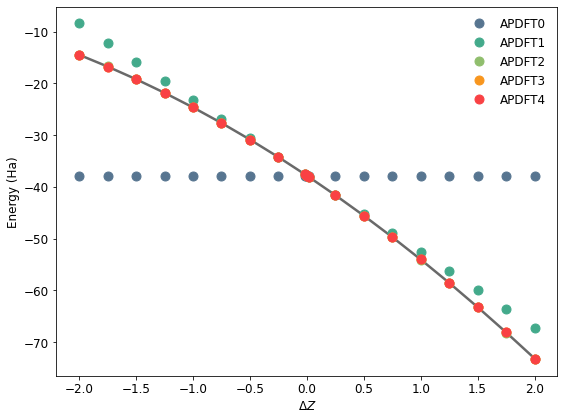

In [4]:
ref_charge = 0  # From -2 to 2.

df_qc_sys = df_qc.query(
    'n_electrons == @n_electrons'
    '& charge == @ref_charge'
    '& basis_set == @basis_set'
)

if len(set(df_qc_sys['multiplicity'].values)) > 1:
    sys_multiplicity = get_multiplicity(df_qc_sys, excitation_level)
    df_qc_sys = df_qc_sys.query('multiplicity == @sys_multiplicity')
else:
    sys_multiplicity = df_qc_sys.iloc[0]['multiplicity']

df_apdft_sys = df_apdft.query(
    'n_electrons == @n_electrons'
    '& charge == @ref_charge'
    '& basis_set == @basis_set'
    '& multiplicity == @sys_multiplicity'
)
poly_coeffs = df_apdft_sys.iloc[0]['poly_coeff']

lambda_sort = np.argsort(df_qc_sys['lambda_value'].values)

lambda_values = df_qc_sys['lambda_value'].values[lambda_sort]
e_qc = df_qc_sys['electronic_energy'].values[lambda_sort]
e_apdft = np.zeros((len(poly_coeffs), len(lambda_values)))

for order in range(len(poly_coeffs)):
    e_apdft[order] = np.array(
        [calc_apdft_pred(poly_coeffs, order, l_value)[0] for l_value in lambda_values]
    )

###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

order_colors = [
    '#577590', '#43AA8B', '#90BE6D', '#F8961E', '#F94144'
]

# Alchemical PES
ax.plot(
    lambda_values, e_qc,
    color='dimgrey', linewidth=2.5,
    #label='Alchemy'
)

for order in range(len(poly_coeffs)):
    ax.plot(
        lambda_values, e_apdft[order],
        color=order_colors[order],
        marker='o', markersize=9, fillstyle='full',
        linestyle='', label=f'APDFT{order}'
    )

ax.set_xlabel('$\Delta Z$')

ax.set_ylabel('Energy (Ha)')

ax.legend(frameon=False)

### Three panel

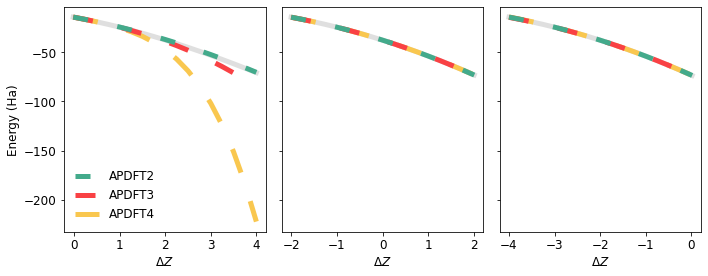

In [5]:
ref_charges = [-2, 0, 2]
apdft_orders = [2, 3, 4]

all_energies = []
all_qc_energies = []
all_lambda_values = []

for ref_charge in ref_charges:

    # Neutral charge QA PES
    df_qc_sys = df_qc.query(
        'n_electrons == @n_electrons'
        '& charge == @ref_charge'
        '& basis_set == @basis_set'
    )
    sys_multiplicity = get_multiplicity(df_qc_sys, excitation_level)
    df_qc_sys = df_qc_sys.query('multiplicity == @sys_multiplicity')


    df_apdft_sys = df_apdft.query(
        'n_electrons == @n_electrons'
        '& charge == @ref_charge'
        '& basis_set == @basis_set'
        '& multiplicity == @sys_multiplicity'
    )
    poly_coeffs = df_apdft_sys.iloc[0]['poly_coeff']

    lambda_sort = np.argsort(df_qc_sys['lambda_value'].values)

    lambda_values = df_qc_sys['lambda_value'].values[lambda_sort]
    e_qc = df_qc_sys['electronic_energy'].values[lambda_sort]
    e_apdft = np.zeros((len(apdft_orders), len(lambda_values)))

    for j in range(len(apdft_orders)):
        order = apdft_orders[j]
        e_apdft[j] = np.array(
            [calc_apdft_pred(poly_coeffs, order, l_value)[0] for l_value in lambda_values]
        )
    all_qc_energies.append(e_qc)
    all_energies.append(e_apdft)
    all_lambda_values.append(lambda_values)

###   FIGURE   ###
fig, axes = plt.subplots(1, 3, tight_layout=True, sharey=True, figsize=(10,4))
fig.patch.set_facecolor('white')
markers = ['o', 'o', 'o', 'o']
order_colors = [
    '#43AA8B', '#F94144', '#F9C74F', '#F8961E', '#F94144'
]
line_width = 5

# Alchemical PES
for i in range(3):
    ax = axes[i]
    lambda_values = all_lambda_values[i]
    e_qc = all_qc_energies[i]
    e_apdft = all_energies[i]

    ax.plot(
        lambda_values, e_qc,
        color='silver', linewidth=line_width,
        zorder=0, alpha=0.5
    )

    for j in range(len(apdft_orders)):
        apdft_order = apdft_orders[j]
        """
        ax.plot(
            lambda_values, e_apdft[j],
            color=order_colors[j],
            marker=markers[j], markersize=10, fillstyle='none', markeredgewidth=1.25,
            linestyle='', label=f'APDFT{apdft_order}',
            zorder=4-j
        )
        """
        ax.plot(
            lambda_values, e_apdft[j],
            color=order_colors[j],
            marker='', markersize=0.5, fillstyle='none', markeredgewidth=1.25,
            linestyle=(0, (3+j*1, 6)), linewidth=line_width, label=f'APDFT{apdft_order}',
            zorder=4-j
        )

    ax.set_xlabel('$\Delta Z$')

axes[0].set_ylabel('Energy (Ha)')

axes[0].legend(frameon=False)

print()

### Lolliplot for APDFT

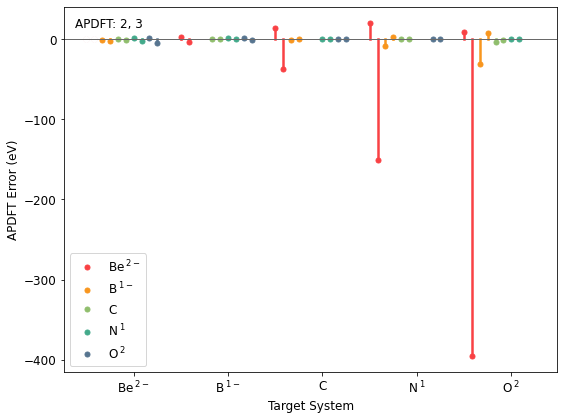

In [6]:
return_energies = False
apdft_orders = [2, 3]


all_energies = []

for apdft_order in apdft_orders:
    state_labels, energies = get_apdft_errors(
        df_qc, df_apdft, n_electrons, apdft_order=apdft_order, excitation_level=excitation_level,
        basis_set=basis_set, return_energies=return_energies,
    )
    energies = hartree_to_ev(energies)
    all_energies.append(energies)
all_energies = np.array(all_energies)

system_labels_condensed = []
for state_label in state_labels:
    split = state_label.split('.')
    sys_label = split[0].capitalize()
    charge = str(split[1][4:])
    if charge[0] == '-':
        charge = charge[1] + '-'
    if charge == '0':
        charge = ''
    system_labels_condensed.append(sys_label + '$\,^{' + charge + '}$')

marker_size = 5
line_width = 2.5


order_offset = 0.1 + len(apdft_orders)*0.2
ref_offset = order_offset*len(apdft_orders)
target_offset = ref_offset*(len(state_labels)+1)


###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
sys_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]

for order_i in range(len(apdft_orders)):
    if order_i == 0:
        order_offset_plot = 0
    else:
        order_offset_plot = order_offset * order_i
    for i in range(len(system_labels_condensed)):
        energies = all_energies[order_i,i,:]

        x = [i*target_offset+j*ref_offset+order_offset_plot for j in range(i+len(energies))]
        for j in range(len(system_labels_condensed)):
            if i == j and i != 0:
                color = 'white'
            else:
                color = sys_colors[j]

            ax.plot(
                [x[j], x[j]], [0, energies[j]],
                marker='', markersize=0, 
                linestyle='-', linewidth=line_width,
                color=color
            )
            if i == 0:
                label = system_labels_condensed[j]
                if j == 0:
                    ax.plot(
                        x[j], energies[j],
                        marker='o', markersize=marker_size+1, 
                        linestyle='', linewidth=0,
                        color='white', markeredgecolor=None,
                        zorder=2
                    )
            else:
                label = None
            if order_i > 0:
                label = None
                

            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color, markeredgecolor=None,
                label=label, zorder=1
            )
        

ax.set_xlabel('Target System')
xlabel_spacing = [i*target_offset+(target_offset/2) for i in range(len(state_labels))]
ax.set_xticks(xlabel_spacing)
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('APDFT Error (eV)')
ax.axhline(0, color='dimgrey', linewidth=1)

anchored_text = AnchoredText(
    f"APDFT: " + ', '.join([str(i) for i in apdft_orders]),
    loc='upper left', frameon=False
)
ax.add_artist(anchored_text)

ax.legend()


### Heatmaps

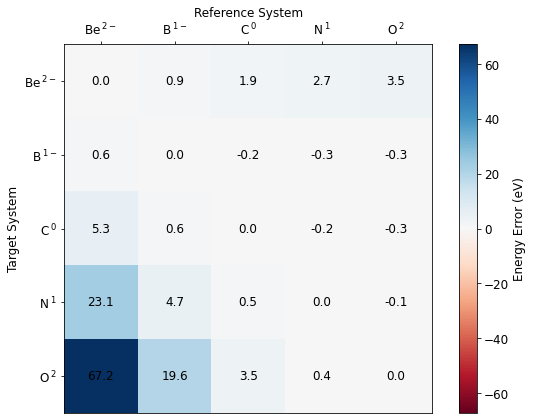

In [7]:
# PES
return_energies = True
state_labels, energy_errors = get_alchemical_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set
)
system_labels_condensed = []
for state_label in state_labels:
    split = state_label.split('.')
    sys_label = split[0].capitalize()
    charge = str(split[1][4:])
    if charge[0] == '-':
        charge = charge[1] + '-'
    system_labels_condensed.append(sys_label + '$\,^{' + charge + '}$')

# Heatmap with error.
energy_errors = hartree_to_ev(energy_errors)
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
max_abs_error = np.max(np.abs(energy_errors.flatten()))
end_buffer = 0

divnorm=colors.TwoSlopeNorm(
    vmin=-max_abs_error-end_buffer, vcenter=0., vmax=max_abs_error+end_buffer
)
img = ax.imshow(
    energy_errors, cmap='RdBu', norm=divnorm
)

for (j,i),error in np.ndenumerate(energy_errors):
    ax.text(i, j, f'{error:.1f}', ha='center', va='center')

ax.set_xlabel('Reference System')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticks(range(0, len(system_labels_condensed)))
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Target System')
ax.set_yticks(range(0, len(system_labels_condensed)))
ax.set_yticklabels(system_labels_condensed)

fig.colorbar(img, label='Energy Error (eV)')

## Lolliplot errors by energy contribution

Energies (eV)
[[-2.08920079 -2.45647763 -2.71407605 -2.82407402 -2.84556983]
 [-2.96869457 -3.19226916 -3.37108023 -3.49819004 -3.55824034]
 [-2.86893067 -3.17350279 -3.42410913 -3.60755191 -3.72307494]
 [-2.77270523 -3.09727864 -3.42484345 -3.6583753  -3.80218702]
 [-2.67423346 -2.97392745 -3.35158478 -3.64686013 -3.830206  ]]

 Percent error (Error/Energies)
[[ -0.          14.95136103  23.02349876  26.02174118  26.58058286]
 [ -7.53107411  -0.           5.30426622   8.74511902  10.2851733 ]
 [-19.35140728  -7.89683686  -0.           5.08496576   8.03007763]
 [-31.94245332 -18.11579529  -6.81875978  -0.           3.78234201]
 [-43.22631354 -28.79285246 -14.28044497  -5.02749926  -0.        ]]


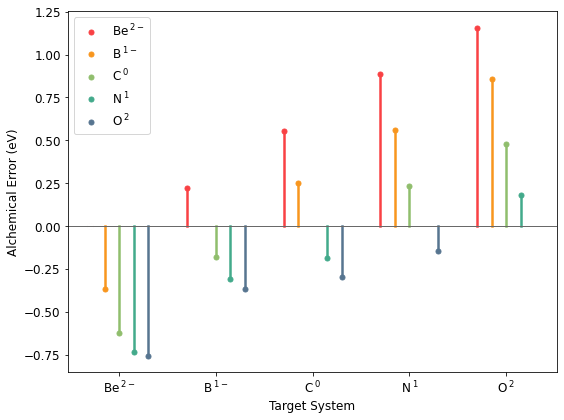

In [8]:
energy_type = 'correlation'  # total, hf, correlation
return_energies = False

state_labels, all_energies = get_alchemical_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=return_energies,
    energy_type=energy_type
)

_, all_energies_test = get_alchemical_errors(
    df_qc, n_electrons, excitation_level=excitation_level,
    basis_set=basis_set, return_energies=True,
    energy_type=energy_type
)
print('Energies (eV)')
print(hartree_to_ev(all_energies_test))
print('\n Percent error (Error/Energies)')
print(hartree_to_ev(all_energies)/hartree_to_ev(all_energies_test)*100)

system_labels_condensed = []
for state_label in state_labels:
    split = state_label.split('.')
    sys_label = split[0].capitalize()
    charge = str(split[1][4:])
    if charge[0] == '-':
        charge = charge[1] + '-'
    system_labels_condensed.append(sys_label + '$\,^{' + charge + '}$')

marker_size = 5
line_width = 2.5
j_offset = 0.15


###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
sys_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]

for i in range(len(system_labels_condensed)):
    energies = hartree_to_ev(all_energies[i,:])

    x = [i+j*j_offset for j in range(i+len(energies))]
    for j in range(len(system_labels_condensed)):
        if i == j and i != 0:
            color = 'white'
        else:
            color = sys_colors[j]
        
        ax.plot(
            [x[j], x[j]], [0, energies[j]],
            marker='', markersize=0, 
            linestyle='-', linewidth=line_width,
            color=color
        )
        if i == 0:
            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color, label=system_labels_condensed[j]
            )
            if j == 0:
                ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size+2, 
                linestyle='', linewidth=0,
                color='white', markeredgecolor='white'
            )
        else:
            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color
            )


ax.set_xlabel('Target System')
xlabel_offset = ((len(state_labels)-1)/2)*j_offset
xlabel_spacing = [i+xlabel_offset for i in range(len(state_labels))]
ax.set_xticks(xlabel_spacing)
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Alchemical Error (eV)')
ax.axhline(0, color='dimgrey', linewidth=1)

ax.legend()
